In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import numpy as np
import pandas as pd
import warnings
from matplotlib import pyplot as plt
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
from nilearn.reporting import make_glm_report
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
sys.path.append('..')
from utils.data import Subject, load_participant_list, create_dummy_regressors
from utils.analysis import compute_parametric_modulator

In [4]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

sub_ids = load_participant_list(base_dir)

In [5]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '14', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [ ]:
model_params = {
    'model_name': 'null_durations',
    'tr': 2.33384,
    'hrf_model': 'spm',
    'noise_model': 'ar1',
    'smoothing_fwhm': 5,
    'motion_type': 'basic',
    'include_physio': True,
    'brain_mask': True,
    'fd_thresh': 0.5,
    'std_dvars_thresh': 2,
    'exclusion_threshold': 0.2,
    'scrub': 'dummies',
    'modulators': 'both',
    'modulator_normalization': 'zscore',
    'exclude_stimuli': True,
    'duration': 'all',
    'iti_included': False
}

run = 'test'

In [ ]:
model_name = model_params['model_name']
tr = model_params['tr']
hrf_model = model_params['hrf_model']
noise_model = model_params['noise_model']
smoothing_fwhm = model_params['smoothing_fwhm']
motion_type = model_params['motion_type']
include_physio = model_params['include_physio']
fd_thresh = model_params['fd_thresh']
std_dvars_thresh = model_params['std_dvars_thresh']
exclusion_threshold = model_params['exclusion_threshold']
scrub = model_params['scrub']
modulators = model_params['modulators']
modulator_normalization = model_params['modulator_normalization']
exclude_stimuli = model_params['exclude_stimuli']
brain_mask = model_params['brain_mask']
duration= model_params['duration']
iti_included = model_params['iti_included']

In [8]:
# Load confounds
confounds, sample_mask = subject.load_confounds(run, motion_type=motion_type,
                                                fd_thresh=fd_thresh, std_dvars_thresh=std_dvars_thresh,
                                                scrub=(0 if scrub == 'dummies' else scrub))
if include_physio:
    physio_regressors = subject.load_physio_regressors(run)
    confounds = confounds.join(physio_regressors)

In [9]:
if scrub == 'dummies':
    dummies = create_dummy_regressors(sample_mask, len(confounds))
    confounds = pd.concat([confounds, dummies], axis=1)

In [11]:
# Load fMRI volume
img_path = subject.img.get(run)
fmri_img = load_img(img_path)

In [12]:
if brain_mask:
    brain_mask_path = subject.brain_mask.get(run)
    brain_mask = load_img(brain_mask_path)
else:
    brain_mask = None

n = fmri_img.shape[-1]
frametimes = np.linspace(tr / 2., (n - .5) * tr, n)

In [13]:
if modulators == 'both':
    columns_event = {'first_stim_value_rl':'first_stim_presentation',
                    'first_stim_value_ck':'first_stim_presentation',
                    'first_stim':'first_stim_presentation'}
    # Load events
    events = getattr(subject, run).extend_events_df(columns_event)
elif modulators == 'none':
    events = getattr(subject, run).events
else:
    raise NotImplementedError("Modulator type not implemented")

In [14]:
if exclude_stimuli:
    events['trial_type'] = events.apply(
        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
        if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
        axis=1
    ) 

In [27]:
# Handle the duration of events
if duration == 'none':
    events['duration'] = 0
elif duration == 'all':
    pass
else:
    raise ValueError("Invalid duration type. Must be 'none' or 'all'")

In [28]:
# Handle the ITI
if not iti_included:
    events = events[events['trial_type'] != 'iti']
else:
    pass

In [29]:
events.head(15)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck,first_stim
0,0.010973,0,first_stim_presentation_include,1,4.0,0.033216,6.0
1,0.844980,0,second_stim_presentation,1,0.0,0.000000,0.0
2,1.375436,0,response,1,0.0,0.000000,0.0
3,1.378825,0,purple_frame,1,0.0,0.000000,0.0
5,9.719933,0,first_stim_presentation_include,2,3.0,0.060569,4.0
6,10.587313,0,second_stim_presentation,2,0.0,0.000000,0.0
7,11.086353,0,response,2,0.0,0.000000,0.0
8,11.104477,0,purple_frame,2,0.0,0.000000,0.0
10,19.662456,0,first_stim_presentation_include,3,4.0,0.035198,6.0
11,20.629936,0,second_stim_presentation,3,0.0,0.000000,0.0


In [20]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    add_regs=confounds)

In [21]:
if modulators == 'both':
    # RL Parametric modulation
    parametric_modulator_column = 'first_stim_value_rl'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(1, parametric_modulator_column, reg_value)

    # CK Parametric modulation
    parametric_modulator_column = 'first_stim_value_ck'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(2, parametric_modulator_column, reg_value)

<Axes: label='conditions', ylabel='scan number'>

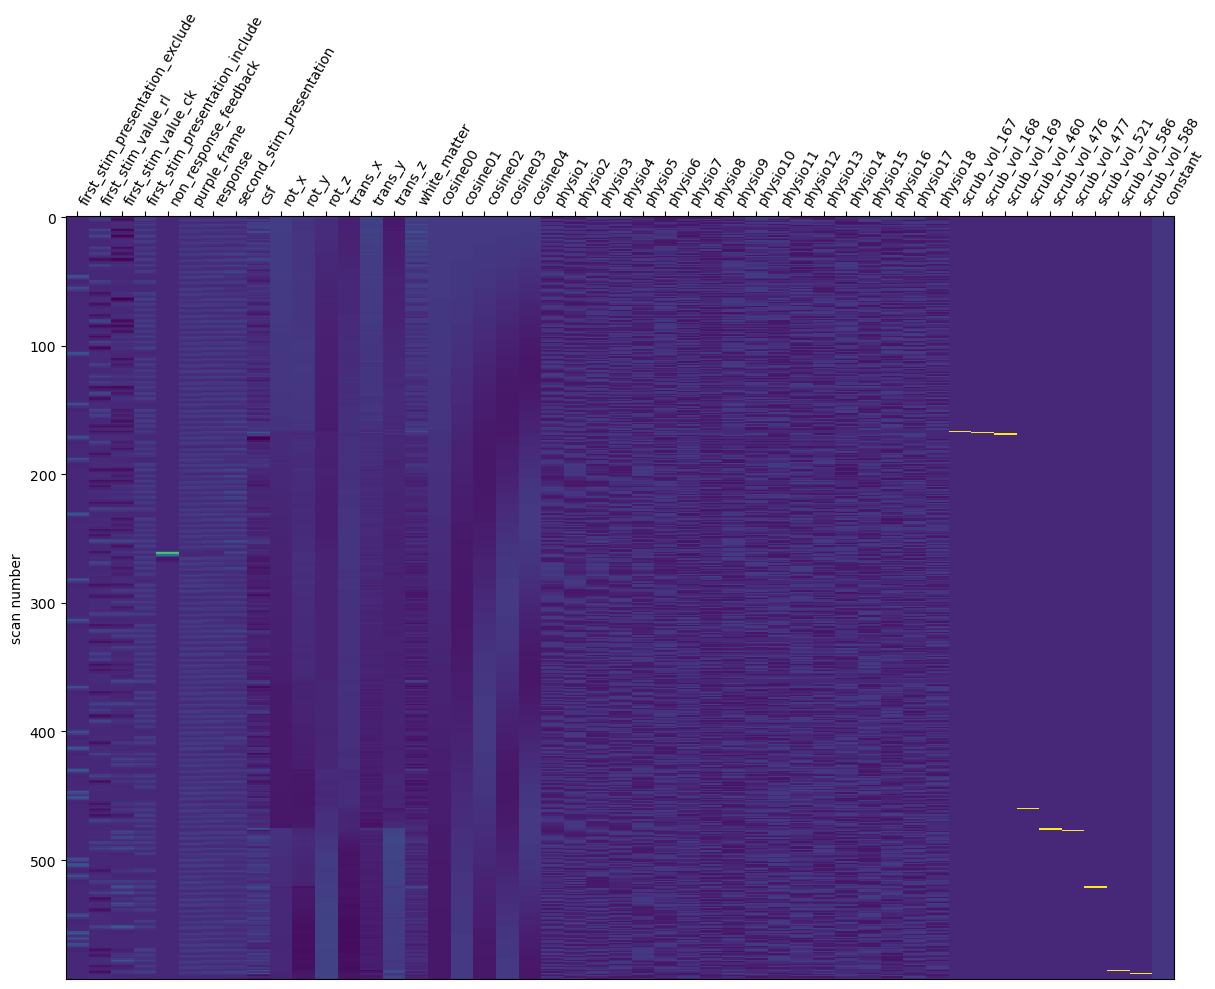

In [22]:
plot_design_matrix(design_matrix)